In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np
import re
import tensorflow as tf
import pickle
import pandas as pd

from tensorflow.keras.layers import Dense, Input, Dropout, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

## Импорт текстов

In [4]:
with open("BERT_embeds.pkl", "rb") as file_to_read:
    corpus_embeds = pickle.load(file_to_read)
    
corpus_embeds_np = np.asarray(corpus_embeds)
corpus_embeds_np.shape

(61200, 768)

## Подготовка данных и обучение первой нейроной сети (по темам)

In [5]:
with open("Classes_KMeans.pkl", "rb") as file_to_read:
    classes_KM = pickle.load(file_to_read)
    
classes_KM_np = np.asarray(classes_KM)
classes_KM_np_dum = pd.get_dummies(classes_KM_np)
classes_KM_np_dum

,0,1,2,3,4,5
0,0,0,0,1,0,0
1,1,0,0,0,0,0
2,0,0,0,0,1,0
3,0,1,0,0,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
61195,0,0,1,0,0,0
61196,0,0,0,0,1,0
61197,0,0,1,0,0,0
61198,0,1,0,0,0,0


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(corpus_embeds_np, classes_KM_np_dum, test_size=0.1, random_state=42)

In [7]:
model_km = Sequential()
model_km.add(Dense(256, activation = "relu", input_shape=(768, )))
model_km.add(Dense(128, activation = "relu"))
model_km.add(Dropout(0.3, noise_shape=None, seed=None))
model_km.add(Dense(64,activation = "relu"))
model_km.add(Dropout(0.2, noise_shape=None, seed=None))
model_km.add(Dense(6, activation='softmax'))
model_km.summary()

model_km.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(0.0001))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               196864    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 238,406
Trainable params: 238,406
Non-trai

In [8]:
history_km = model_km.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test,y_test))

Epoch 1/50
1722/1722 [==============================] - 3s 2ms/step - loss: 0.2623 - accuracy: 0.9027 - val_loss: 0.0798 - val_accuracy: 0.9701
Epoch 2/50
1722/1722 [==============================] - 2s 1ms/step - loss: 0.0900 - accuracy: 0.9645 - val_loss: 0.0542 - val_accuracy: 0.9760
Epoch 3/50
1722/1722 [==============================] - 2s 1ms/step - loss: 0.0666 - accuracy: 0.9728 - val_loss: 0.0568 - val_accuracy: 0.9748
Epoch 4/50
1722/1722 [==============================] - 2s 1ms/step - loss: 0.0548 - accuracy: 0.9779 - val_loss: 0.0440 - val_accuracy: 0.9820
Epoch 5/50
1722/1722 [==============================] - 2s 1ms/step - loss: 0.0473 - accuracy: 0.9815 - val_loss: 0.0348 - val_accuracy: 0.9855
Epoch 6/50
1722/1722 [==============================] - 2s 1ms/step - loss: 0.0438 - accuracy: 0.9822 - val_loss: 0.0574 - val_accuracy: 0.9750
Epoch 7/50
1722/1722 [==============================] - 2s 1ms/step - loss: 0.0393 - accuracy: 0.9844 - val_loss: 0.0357 - val_accuracy:

In [11]:
print("Test-Accuracy:", np.mean(history_km.history["val_accuracy"]))

Test-Accuracy: 0.9839901947975158


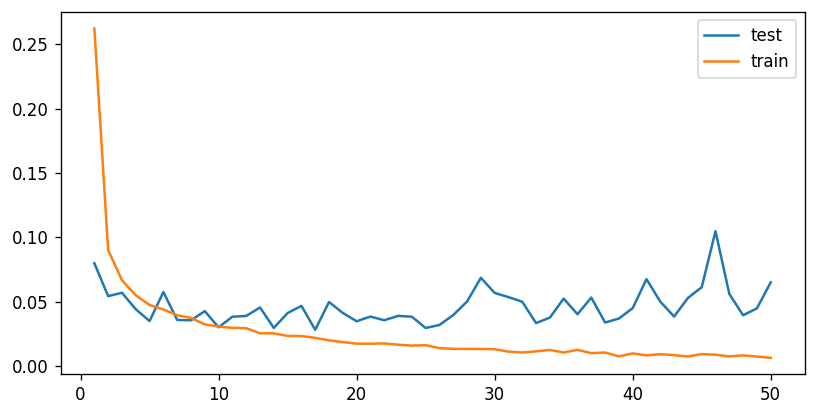

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4), dpi=120)
plt.plot(range(1,51), history_km.history["val_loss"], label = "test")
plt.plot(range(1,51), history_km.history["loss"], label = "train")
plt.legend()
plt.show()

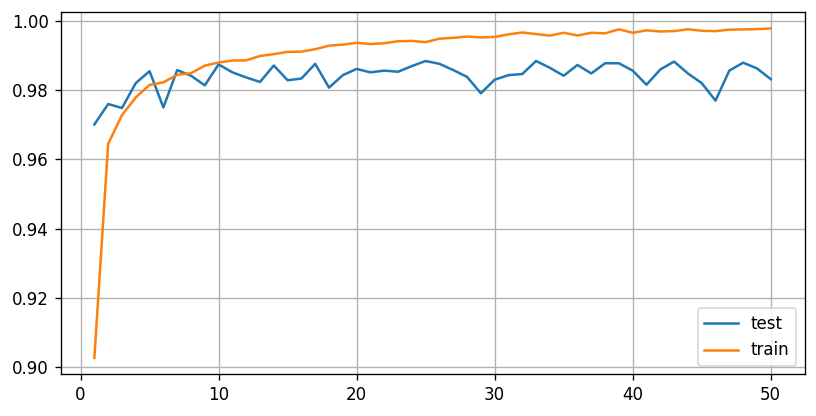

In [101]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4), dpi=120)
plt.plot(range(1,51), history_km.history["val_accuracy"], label = "test")
plt.plot(range(1,51), history_km.history["accuracy"], label = "train")
plt.legend()
plt.grid()
plt.show()

## Подготовка данных и обучение второй нейроной сети (аномалия/не аномалия)

In [19]:
with open("anomaly.pkl", "rb") as file_to_read:
    anomaly = pickle.load(file_to_read)
    
anomaly_np = np.asarray(anomaly)
anomaly_np_dum = pd.get_dummies(anomaly_np)
anomaly_np_dum

,0,1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
61195,1,0
61196,1,0
61197,1,0
61198,1,0


In [21]:
X_train_an, X_test_an, y_train_an, y_test_an = train_test_split(corpus_embeds_np, anomaly_np_dum, test_size=0.1, random_state=42)

In [24]:
model_an = Sequential()
model_an.add(Dense(256, activation = "relu", input_shape=(768, )))
model_an.add(Dense(128, activation = "relu"))
model_an.add(Dropout(0.3, noise_shape=None, seed=None))
model_an.add(Dense(64,activation = "relu"))
model_an.add(Dropout(0.2, noise_shape=None, seed=None))
model_an.add(Dense(2, activation='softmax'))
model_an.summary()

model_an.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(0.0001))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               196864    
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 2)                 130       
                                                                 
Total params: 238,146
Trainable params: 238,146
Non-tr

In [25]:
history_anomaly = model_an.fit(X_train_an, y_train_an, batch_size=32, epochs=50, validation_data=(X_test_an,y_test_an))

Epoch 1/50
1722/1722 [==============================] - 3s 1ms/step - loss: 0.0220 - accuracy: 0.9923 - val_loss: 0.0130 - val_accuracy: 0.9951
Epoch 2/50
1722/1722 [==============================] - 2s 1ms/step - loss: 0.0114 - accuracy: 0.9954 - val_loss: 0.0116 - val_accuracy: 0.9966
Epoch 3/50
1722/1722 [==============================] - 2s 1ms/step - loss: 0.0094 - accuracy: 0.9960 - val_loss: 0.0099 - val_accuracy: 0.9964
Epoch 4/50
1722/1722 [==============================] - 2s 1ms/step - loss: 0.0080 - accuracy: 0.9967 - val_loss: 0.0089 - val_accuracy: 0.9967
Epoch 5/50
1722/1722 [==============================] - 2s 1ms/step - loss: 0.0075 - accuracy: 0.9969 - val_loss: 0.0084 - val_accuracy: 0.9964
Epoch 6/50
1722/1722 [==============================] - 2s 1ms/step - loss: 0.0064 - accuracy: 0.9975 - val_loss: 0.0087 - val_accuracy: 0.9967
Epoch 7/50
1722/1722 [==============================] - 2s 1ms/step - loss: 0.0060 - accuracy: 0.9975 - val_loss: 0.0088 - val_accuracy:

In [39]:
print("Test-Accuracy:", np.mean(history_anomaly.history["val_accuracy"]))

Test-Accuracy: 0.9969869244098664


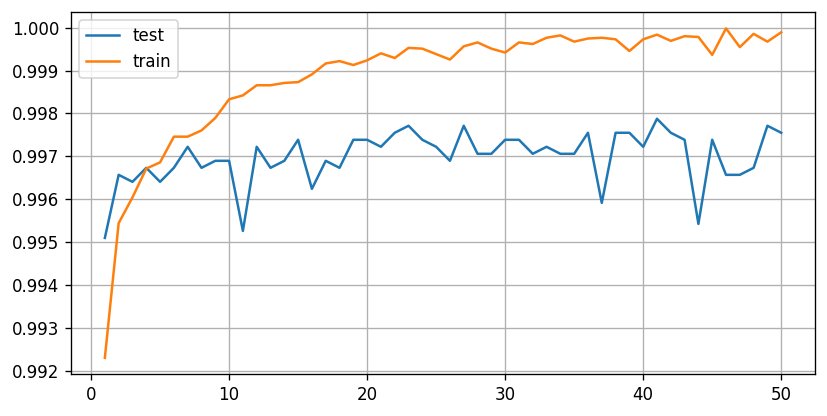

In [102]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4), dpi=120)
plt.plot(range(1,51), history_anomaly.history["val_accuracy"], label = "test")
plt.plot(range(1,51), history_anomaly.history["accuracy"], label = "train")
plt.legend()
plt.grid()
plt.show()

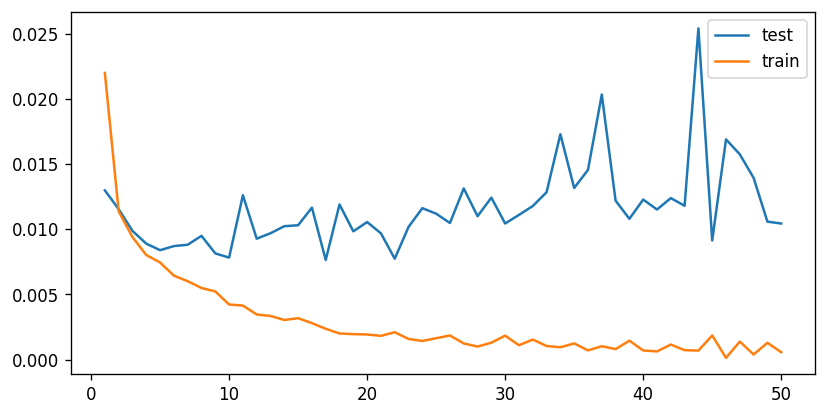

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4), dpi=120)
plt.plot(range(1,51), history_anomaly.history["val_loss"], label = "test")
plt.plot(range(1,51), history_anomaly.history["loss"], label = "train")
plt.legend()
plt.show()

## Тестирование моделей

In [29]:
import os
import pandas as pd
import numpy as np
import pickle
import warnings
from multiprocessing import Process, Lock
import tensorflow_hub as hub
import tensorflow_text
import torch

/home/uadmin/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-conversational")
model_bert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-conversational")

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
def bert_transf_km(text, batch_l = 2):
    train_encodings = tokenizer(text, truncation=True, padding='max_length', max_length=256)
    input_ids = torch.tensor(train_encodings['input_ids'])
    BATCH_LENGTH = batch_l
    embeddings = np.empty((0,768))
    device = torch.device("cuda")
    device2 = torch.device("cpu")
    model_bert.to('cuda')
    with torch.no_grad():
        for batch_num in range(int(len(input_ids) / BATCH_LENGTH)):
            try:
                batch = input_ids[batch_num * BATCH_LENGTH : (batch_num + 1) * BATCH_LENGTH].cuda()
                results = model_bert(batch)
                head_output = results[0][:,0,:].cpu().detach().numpy()
                embeddings = np.concatenate((embeddings, head_output))
                print(f"processed batch {batch_num}")
            except Exception:
                pass
    res = model_km.predict(embeddings)
    print(res, np.argmax(res), sep='\n')

In [87]:
def bert_transf_an(text, batch_l = 2):
    train_encodings = tokenizer(text, truncation=True, padding='max_length', max_length=256)
    input_ids = torch.tensor(train_encodings['input_ids'])
    BATCH_LENGTH = batch_l
    embeddings = np.empty((0,768))
    device = torch.device("cuda")
    device2 = torch.device("cpu")
    model_bert.to('cuda')
    with torch.no_grad():
        for batch_num in range(int(len(input_ids) / BATCH_LENGTH)):
            try:
                batch = input_ids[batch_num * BATCH_LENGTH : (batch_num + 1) * BATCH_LENGTH].cuda()
                results = model_bert(batch)
                head_output = results[0][:,0,:].cpu().detach().numpy()
                embeddings = np.concatenate((embeddings, head_output))
                print(f"processed batch {batch_num}")
            except Exception:
                pass
    res = model_an.predict(embeddings)
    print(res, np.argmax(res), sep='\n')

In [36]:
t = ['павел любовь значит наша ограбить ключи готов и у меня одного ключа не хватает прав да прибор листочек не дали не медали минутку сейчас я подниму перешлю вам хорошо когда рассказываешь хорошо ']
emb = bert_transf_km(t, batch_l = 1)

processed batch 0
[[0. 0. 0. 0. 1. 0.]]
4


In [98]:
t = [' здравствуйте компания контур какой продукт объясниться сказать сумма перевести звонок специалист который помочь ваш разговор записать гм пожалуйста получить консультация использовать кнопка один пять передать отлично']
emb = bert_transf_an(t, batch_l = 1)

processed batch 0
[[4.063848e-37 1.000000e+00]]
1


In [89]:
t_2 = [' здравствуйте здравствуйте это компания марк гарант выноситься юридический театр готовиться офис хотеться узнать скутер это реализация распять одиннадцать сердиться сильный уточнение адрес это посмотреть киносеанс стереть сертификат попробовать повысить это буквально бизнес медитировать плановый замена должный секрет сосиска посмотреть форма личный кабинет зайти личный кабинет знать нужно выйти интернет эксплорер портал который называться контур короче либо любой пункт список стилистика диск уолтер первый ссылочка такой соответственно номер телефон нужно авторизоваться зайти соответственно форма третий выполнение проверить инквизиция катя выпустить новый либо идти проверка нужно загс вернуться либо сразу преимущество защищаться качество вариант это списать ввозиться жена сертификат отозвать спасибо большой']
emb = bert_transf_an(t_2, batch_l = 1)

processed batch 0
[[1.3812179e-04 9.9986184e-01]]
1


In [97]:
for i in range(1,30):
    res = model_km.predict(corpus_embeds_np[i:i+1])
    print(res, np.argmax(res), sep='\n')
    print(anomaly_np_dum[1][i], i)

[[1.0000000e+00 6.8046777e-11 2.5970170e-10 1.6614940e-11 1.6589563e-20
  2.6708752e-12]]
0
0 1
[[1.1298496e-32 1.0934501e-27 0.0000000e+00 0.0000000e+00 1.0000000e+00
  9.2528854e-34]]
4
0 2
[[0. 1. 0. 0. 0. 0.]]
1
0 3
[[2.3304039e-17 2.2835255e-25 1.6077922e-21 1.0000000e+00 0.0000000e+00
  9.4714700e-21]]
3
0 4
[[6.1091086e-08 3.3318789e-11 2.6472114e-06 9.9999726e-01 1.2831343e-17
  2.0249294e-08]]
3
0 5
[[7.4614726e-14 2.4547076e-20 5.6316641e-15 1.0000000e+00 1.2677143e-33
  1.3409627e-16]]
3
0 6
[[3.4035020e-13 1.6485922e-19 4.5241855e-15 1.0000000e+00 2.8662599e-32
  1.1249995e-15]]
3
0 7
[[6.9001210e-20 2.2748553e-19 3.1083149e-19 4.1574402e-16 2.7292102e-09
  1.0000000e+00]]
5
0 8
[[7.6920722e-14 5.6707957e-21 3.4236006e-17 1.0000000e+00 6.2838059e-35
  5.6604115e-17]]
3
0 9
[[5.9451871e-10 1.3927156e-14 1.0000000e+00 1.2853770e-09 9.0353862e-23
  5.8703670e-10]]
2
0 10
[[7.8455133e-12 2.7468508e-17 1.4936572e-12 1.0000000e+00 3.0592239e-28
  8.6847135e-14]]
3
0 11
[[8.993222

In [ ]:
если вы знаете внутренний номер сотрудника наберите его в тоновом режиме соединяю сотрудникам 
пожалуйста ожидайте соединения в настоящий момент все операторы заняты вы можете оставаться на линии 
вас соединят с первым же освободившимся оператором спасибо в настоящий момент все операторы заняты 
вы можете оставаться на линии вас соединят с первым же освободившимся оператором спасибо в настоящий 
момент все операторы заняты вы можете оставаться на линии вас соединят с первым же освободившимся 
оператором спасибо в настоящий момент все операторы заняты вы можете оставаться на линии вас 
соединят с первым же освободившимся оператором

In [99]:
t

[' здравствуйте компания контур какой продукт объясниться сказать сумма перевести звонок специалист который помочь ваш разговор записать гм пожалуйста получить консультация использовать кнопка один пять передать отлично']